# Data

Only date, and maturities 1-20
- plot_data (1,2,3,4,...)
- data2 (SVENY01, SVENY02,...)

In [103]:
import pandas as pd

# Skip the first 9 rows
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter rows where Date is on or after 1985-01-02
data1 = data[data['Date'] >= '1985-01-02']
# List of columns to keep always
cols_to_keep = ['Date']

# Select columns that start with 'SVENY'
sveny_cols = [col for col in data.columns if col.startswith('SVENY')]

# Combine all columns to keep
all_keep_cols = cols_to_keep + sveny_cols

# Filter the dataframe to keep only these columns
data2 = data1[all_keep_cols]

# Check the result
data2.head()

# Drop SVENY21 to SVENY30 from data2
columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')


In [3]:
data2.shape

(10528, 21)

In [4]:
data2.columns

Index(['Date', 'SVENY01', 'SVENY02', 'SVENY03', 'SVENY04', 'SVENY05',
       'SVENY06', 'SVENY07', 'SVENY08', 'SVENY09', 'SVENY10', 'SVENY11',
       'SVENY12', 'SVENY13', 'SVENY14', 'SVENY15', 'SVENY16', 'SVENY17',
       'SVENY18', 'SVENY19', 'SVENY20'],
      dtype='object')

In [5]:
plot_data =data2

# Rename SVENY columns by stripping the prefix
plot_data.rename(columns=lambda col: col[5:] if col.startswith('SVENY') else col, inplace=True)

# Optional: convert new column names from strings like '01' to integers
plot_data.rename(columns=lambda col: str(int(col)) if col.isdigit() else col, inplace=True)

plot_data.columns

Index(['Date', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object')

In [6]:
data = data2.dropna()
print(data.shape)

(10073, 21)


##### split 

In [7]:
from datetime import date

data['Date'] = pd.to_datetime(data['Date']).dt.date

train = data[data['Date'] >= date(1985, 1, 2)] # Filter data from 1985-01-02 onwards
train = train[train['Date'] <= date(2017, 12, 31)] # Filter data up to 2017-12-31

valid = data[data['Date'] >= date(2018, 1, 1)] # Filter data up to 2018-01-01
valid = valid[valid['Date'] <= date(2024, 12, 31)] # Filter data up to 2024-12-31

test = data[data['Date'] >= date(2025, 1, 1)] # Filter data from 2025-01-01 onwards

print(train.shape)
print(valid.shape)
print(test.shape)
print(test.head(1))

(8234, 21)
(1750, 21)
(89, 21)
             Date       1       2       3       4       5       6       7  \
16581  2025-01-02  4.1919  4.2189  4.2541  4.2952  4.3406  4.3886  4.4381   

            8       9  ...      11      12      13      14      15     16  \
16581  4.4878  4.5369  ...  4.6301  4.6732  4.7133  4.7501  4.7834  4.813   

           17      18      19      20  
16581  4.8389  4.8609  4.8791  4.8934  

[1 rows x 21 columns]


/var/folders/0z/k0qzkdjj4rd_2_dy9slhrrkh0000gn/T/ipykernel_23147/2169619868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date']).dt.date


Lav datasæt med maturity 2, 20 og (2,20) 

# Diffusion model

## Første model 

prepare data 

In [71]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

plot_data = plot_data.dropna()
# Extract yield values
yield_data = plot_data.loc[:, '1':'20'].values

# Normalize
scaler = StandardScaler()
normalized_data = scaler.fit_transform(yield_data)

plot_data.shape

(10073, 21)

Learning the model for diffusion 

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenoiseMLP(nn.Module):
    def __init__(self, input_dim):
        super(DenoiseMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, t):
        t = t.unsqueeze(1).float() / T
        x = torch.cat([x, t], dim=1)
        return self.model(x)

Training the model

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# === Load & normalize data ===
df = plot_data
yield_data = df.loc[:, '1':'20'].values.astype(np.float32)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(yield_data)

X = torch.tensor(normalized_data, dtype=torch.float32)

# === Diffusion setup ===
T = 1000
betas = torch.linspace(1e-4, 0.02, T, dtype=torch.float32)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)
alpha_bars = torch.clamp(alpha_bars, min=1e-5)  # avoids division by zero

# === Model ===
class DenoiseMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, t):
        t = t.unsqueeze(1).float() / T
        x = torch.cat([x, t], dim=1)
        return self.model(x)

model = DenoiseMLP(input_dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Training ===
batch_size = 64
num_epochs = 1000

for epoch in range(num_epochs):
    idx = torch.randint(0, X.shape[0], (batch_size,))
    x0 = X[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x0)

    ab = alpha_bars[t].unsqueeze(1)
    xt = torch.sqrt(ab) * x0 + torch.sqrt(1 - ab) * noise
    xt = torch.clamp(xt, -5, 5)  # avoid large values

    pred = model(xt, t)
    loss = F.mse_loss(pred, noise)

    if torch.isnan(loss):
        print("Loss is NaN. Check values:")
        print("xt stats:", xt.mean().item(), xt.std().item())
        break

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 1.025621
Epoch 100: Loss = 0.866977
Epoch 200: Loss = 0.814953
Epoch 300: Loss = 0.634897
Epoch 400: Loss = 0.492763
Epoch 500: Loss = 0.434525
Epoch 600: Loss = 0.285074
Epoch 700: Loss = 0.155341
Epoch 800: Loss = 0.213401
Epoch 900: Loss = 0.202791


In [74]:
@torch.no_grad()
def sample(model, n_samples=1, input_dim=20):
    x = torch.randn(n_samples, input_dim)
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, dtype=torch.long)
        z = torch.randn_like(x) if t > 0 else 0
        alpha_bar = alpha_bars[t]
        beta = betas[t]

        pred_noise = model(x, t_batch)
        x = (1 / torch.sqrt(alphas[t])) * (x - (1 - alphas[t]) / torch.sqrt(1 - alpha_bar) * pred_noise) + torch.sqrt(beta) * z
        x = torch.clamp(x, -5, 5)
    return x

In [75]:
samples = sample(model, n_samples=10)
samples_np = scaler.inverse_transform(samples.numpy())

## Anden model

### Sample random yield curve


#### maturity 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# === Load and preprocess ===
yield_data = train.loc[:, '2'].values.astype(np.float32).reshape(-1, 1)
scaler = StandardScaler()
yield_data = scaler.fit_transform(yield_data)
X = torch.tensor(yield_data.reshape(-1, 1), dtype=torch.float32)

# === Diffusion Parameters ===
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# === Define MLP Model ===
class DenoiseMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
        )

    def forward(self, x, t):
        t = t.unsqueeze(1).float() / T
        x_in = torch.cat([x, t], dim=1)
        return self.model(x_in)

model = DenoiseMLP(dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

# === Noise sampling function ===
def q_sample(x0, t, noise):
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bars[t])[:, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

# === Training Loop ===
epochs = 10000
batch_size = 128

for epoch in tqdm(range(epochs)):
    idx = torch.randint(0, X.shape[0], (batch_size,))
    x0 = X[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred = model(xt, t)
    loss = F.mse_loss(pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# === Sampling function to generate new curves ===
@torch.no_grad()
def sample(model, n=1):
    x = torch.randn(n, 1)
    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, dtype=torch.long)
        pred_noise = model(x, t_tensor)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(torch.clamp(1 - alpha_bar_t, min=1e-5))
        sqrt_beta_t = torch.sqrt(beta_t)

        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)

        x = (1 / sqrt_alpha_t) * (x - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise) + sqrt_beta_t * noise

    # Make sure shape is correct
    return scaler.inverse_transform(x.cpu().numpy().reshape(-1, 1))
# === Generate and print a new yield curve ===


  3%|▎         | 317/10000 [00:00<00:05, 1724.05it/s]

Epoch 0 | Loss: 0.9636


  8%|▊         | 781/10000 [00:00<00:04, 2098.43it/s]

Epoch 500 | Loss: 0.2721


 15%|█▍        | 1481/10000 [00:00<00:04, 2045.12it/s]

Epoch 1000 | Loss: 0.3029


 20%|█▉        | 1972/10000 [00:00<00:03, 2246.96it/s]

Epoch 1500 | Loss: 0.3520


 25%|██▍       | 2466/10000 [00:01<00:03, 2362.00it/s]

Epoch 2000 | Loss: 0.3046
Epoch 2500 | Loss: 0.2136


 35%|███▍      | 3481/10000 [00:01<00:02, 2474.95it/s]

Epoch 3000 | Loss: 0.2870


 40%|███▉      | 3974/10000 [00:01<00:02, 2408.20it/s]

Epoch 3500 | Loss: 0.1122


 45%|████▍     | 4460/10000 [00:01<00:02, 2405.32it/s]

Epoch 4000 | Loss: 0.2320


 49%|████▉     | 4941/10000 [00:02<00:02, 2377.18it/s]

Epoch 4500 | Loss: 0.2461


 54%|█████▍    | 5434/10000 [00:02<00:01, 2409.09it/s]

Epoch 5000 | Loss: 0.1832


 59%|█████▉    | 5920/10000 [00:02<00:01, 2375.83it/s]

Epoch 5500 | Loss: 0.3470


 62%|██████▏   | 6158/10000 [00:02<00:01, 2082.94it/s]

Epoch 6000 | Loss: 0.2198


 69%|██████▉   | 6905/10000 [00:03<00:01, 2334.11it/s]

Epoch 6500 | Loss: 0.3972


 74%|███████▍  | 7394/10000 [00:03<00:01, 2368.23it/s]

Epoch 7000 | Loss: 0.2470


 79%|███████▉  | 7881/10000 [00:03<00:00, 2368.27it/s]

Epoch 7500 | Loss: 0.3611


 84%|████████▍ | 8393/10000 [00:03<00:00, 2464.24it/s]

Epoch 8000 | Loss: 0.3398
Epoch 8500 | Loss: 0.2806


 94%|█████████▍| 9421/10000 [00:04<00:00, 2474.23it/s]

Epoch 9000 | Loss: 0.1993


 99%|█████████▉| 9918/10000 [00:04<00:00, 2416.94it/s]

Epoch 9500 | Loss: 0.3077


100%|██████████| 10000/10000 [00:04<00:00, 2311.63it/s]


Generated maturity 2 yields: [ 5.480924    0.9154438   6.096011    9.765681   -0.01841103  4.804854
  6.630351    0.10703886  0.44741857  1.1547474  -0.03789174  0.8691026
  6.288496    7.6942124   0.681177    7.0397773  10.803918    0.90841997
  8.646266    2.8929157 ]


Generated yield curve: [[ 5.480924  ]
 [ 0.9154438 ]
 [ 6.096011  ]
 [ 9.765681  ]
 [-0.01841103]
 [ 4.804854  ]
 [ 6.630351  ]
 [ 0.10703886]
 [ 0.44741857]
 [ 1.1547474 ]
 [-0.03789174]
 [ 0.8691026 ]
 [ 6.288496  ]
 [ 7.6942124 ]
 [ 0.681177  ]
 [ 7.0397773 ]
 [10.803918  ]
 [ 0.90841997]
 [ 8.646266  ]
 [ 2.8929157 ]]


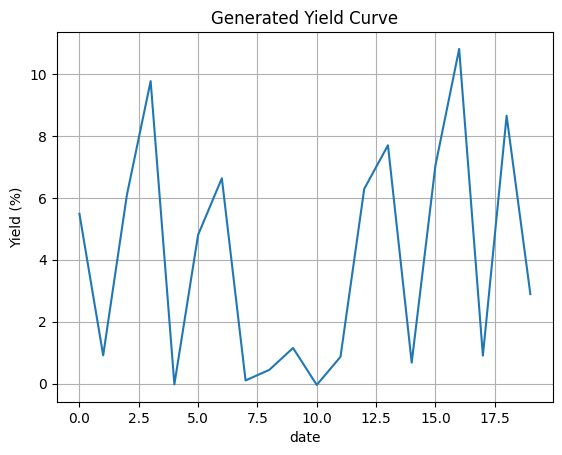

In [ ]:
generated_yields = sample(model, n=20)
print("Generated maturity 2 yields:", generated_yields.flatten())
print("Generated yield curve:", generated_yields)
import matplotlib.pyplot as plt

plt.plot(generated_yields)
plt.xlabel("date")
plt.ylabel("Yield (%)")
plt.title("Generated Yield Curve for maturity 2")
plt.grid(True)
plt.show()

#### maturity 20

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# === Load and preprocess ===
yield_data = train.loc[:, '20'].values.astype(np.float32).reshape(-1, 1)
scaler = StandardScaler()
yield_data = scaler.fit_transform(yield_data)
X = torch.tensor(yield_data.reshape(-1, 1), dtype=torch.float32)

# === Diffusion Parameters ===
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# === Define MLP Model ===
class DenoiseMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
        )

    def forward(self, x, t):
        t = t.unsqueeze(1).float() / T
        x_in = torch.cat([x, t], dim=1)
        return self.model(x_in)

model = DenoiseMLP(dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

# === Noise sampling function ===
def q_sample(x0, t, noise):
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bars[t])[:, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

# === Training Loop ===
epochs = 10000
batch_size = 128

for epoch in tqdm(range(epochs)):
    idx = torch.randint(0, X.shape[0], (batch_size,))
    x0 = X[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred = model(xt, t)
    loss = F.mse_loss(pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# === Sampling function to generate new curves ===
@torch.no_grad()
def sample(model, n=1):
    x = torch.randn(n, 1)
    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, dtype=torch.long)
        pred_noise = model(x, t_tensor)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(torch.clamp(1 - alpha_bar_t, min=1e-5))
        sqrt_beta_t = torch.sqrt(beta_t)

        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)

        x = (1 / sqrt_alpha_t) * (x - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise) + sqrt_beta_t * noise

    # Make sure shape is correct
    return scaler.inverse_transform(x.cpu().numpy().reshape(-1, 1))
# === Generate and print a new yield curve ===


  5%|▍         | 482/10000 [00:00<00:03, 2425.83it/s]

Epoch 0 | Loss: 0.9969


 10%|▉         | 965/10000 [00:00<00:03, 2389.90it/s]

Epoch 500 | Loss: 0.3458


 15%|█▍        | 1451/10000 [00:00<00:03, 2409.29it/s]

Epoch 1000 | Loss: 0.3264


 19%|█▉        | 1938/10000 [00:00<00:03, 2420.28it/s]

Epoch 1500 | Loss: 0.3791


 24%|██▍       | 2440/10000 [00:01<00:03, 2467.28it/s]

Epoch 2000 | Loss: 0.2167
Epoch 2500 | Loss: 0.3248


 35%|███▍      | 3463/10000 [00:01<00:02, 2552.44it/s]

Epoch 3000 | Loss: 0.2983
Epoch 3500 | Loss: 0.2369


 45%|████▍     | 4494/10000 [00:01<00:02, 2471.91it/s]

Epoch 4000 | Loss: 0.2880
Epoch 4500 | Loss: 0.3572


 55%|█████▌    | 5507/10000 [00:02<00:01, 2515.31it/s]

Epoch 5000 | Loss: 0.2255
Epoch 5500 | Loss: 0.2462


 63%|██████▎   | 6282/10000 [00:02<00:01, 2563.52it/s]

Epoch 6000 | Loss: 0.3467
Epoch 6500 | Loss: 0.2347


 73%|███████▎  | 7327/10000 [00:02<00:01, 2595.93it/s]

Epoch 7000 | Loss: 0.2894
Epoch 7500 | Loss: 0.2873


 84%|████████▎ | 8370/10000 [00:03<00:00, 2590.89it/s]

Epoch 8000 | Loss: 0.1562
Epoch 8500 | Loss: 0.1673


 94%|█████████▍| 9413/10000 [00:03<00:00, 2599.79it/s]

Epoch 9000 | Loss: 0.2593
Epoch 9500 | Loss: 0.1227


100%|██████████| 10000/10000 [00:04<00:00, 2499.80it/s]


Generated maturity 20 yields: [ 3.1832893  3.1943512  8.5195465  3.3685303  5.3431315  8.459814
  5.443365   3.820549   4.6469417  7.174722   5.436322   2.9306502
  5.0398283  4.0735607  5.61387    9.561744   3.4440446  3.0013525
 12.602739   8.698649 ]


Generated maturity 20 yields: [ 4.73058    3.6236172 11.842      8.132667   4.2305436  3.621982
  6.092277   9.460247   5.198277   8.491382   6.449736   8.269724
  5.191516   5.845216   6.1019597  5.5957355  4.989156   4.8625226
  2.1675024  3.0281842]
Generated yield curve: [[ 4.73058  ]
 [ 3.6236172]
 [11.842    ]
 [ 8.132667 ]
 [ 4.2305436]
 [ 3.621982 ]
 [ 6.092277 ]
 [ 9.460247 ]
 [ 5.198277 ]
 [ 8.491382 ]
 [ 6.449736 ]
 [ 8.269724 ]
 [ 5.191516 ]
 [ 5.845216 ]
 [ 6.1019597]
 [ 5.5957355]
 [ 4.989156 ]
 [ 4.8625226]
 [ 2.1675024]
 [ 3.0281842]]


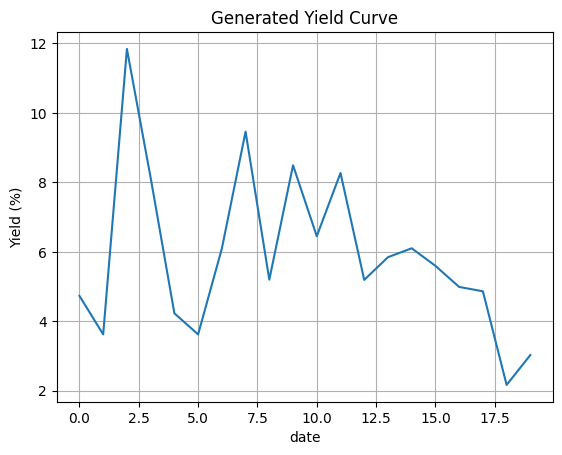

In [84]:
generated_yields = sample(model, n=20)
print("Generated maturity 20 yields:", generated_yields.flatten())

print("Generated yield curve:", generated_yields)
import matplotlib.pyplot as plt

plt.plot(generated_yields)
plt.xlabel("date")
plt.ylabel("Yield (%)")
plt.title("Generated Yield Curve")
plt.grid(True)
plt.show()

### Predict next days yield


 17%|█▋        | 172/1000 [00:00<00:00, 924.07it/s]

Epoch 0 | Loss: nan


 53%|█████▎    | 526/1000 [00:00<00:00, 1126.90it/s]

Epoch 300 | Loss: nan


 76%|███████▌  | 762/1000 [00:00<00:00, 1152.90it/s]

Epoch 600 | Loss: nan


100%|██████████| 1000/1000 [00:00<00:00, 1122.17it/s]


Epoch 900 | Loss: nan


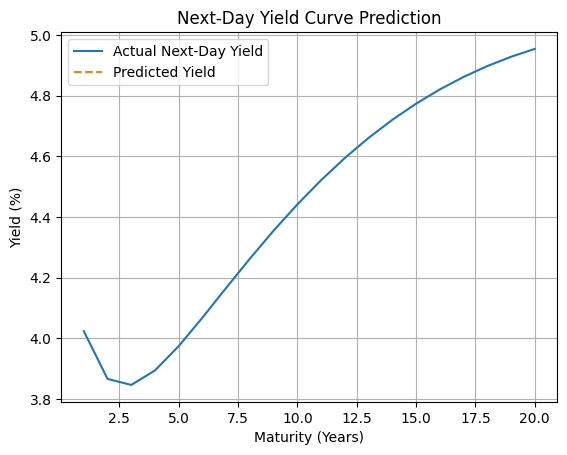

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# === Load & preprocess data ===
yield_data = train.loc[:, '1':'20'].values.astype(np.float32)

# Standardize per maturity
scaler = StandardScaler()
yield_data = scaler.fit_transform(yield_data)

# Create (x_prev, x_next) pairs
X_prev = torch.tensor(yield_data[:-1], dtype=torch.float32)
X_next = torch.tensor(yield_data[1:], dtype=torch.float32)

# === Diffusion Parameters ===
T = 1000  # fewer steps to make it easier to train
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)
alpha_bars = torch.clamp(alpha_bars, min=1e-5)

# === Conditional Denoising Model ===
class CondDenoiseMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim * 2 + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, dim),
        )

    def forward(self, x, t, cond):
        t = t.unsqueeze(1).float() / T
        x_in = torch.cat([x, t, cond], dim=1)
        return self.model(x_in)

model = CondDenoiseMLP(dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Noise function ===
def q_sample(x0, t, noise):
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bars[t])[:, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

# === Training loop ===
epochs = 1000
batch_size = 128

for epoch in tqdm(range(epochs)):
    idx = torch.randint(0, X_prev.shape[0], (batch_size,))
    x_prev = X_prev[idx]
    x_true = X_next[idx]

    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_true)
    xt = q_sample(x_true, t, noise)

    pred = model(xt, t, cond=x_prev)
    loss = F.mse_loss(pred, noise)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# === Sampling: Predict next day's curve given today's ===
@torch.no_grad()
def predict_next_curve(model, x_prev, T=T):
    x = torch.randn(1, 20)
    x_prev = x_prev.unsqueeze(0)

    for t in reversed(range(T)):
        t_tensor = torch.full((1,), t, dtype=torch.long)
        pred_noise = model(x, t_tensor, cond=x_prev)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(torch.clamp(1 - alpha_bar_t, min=1e-8))
        sqrt_beta_t = torch.sqrt(beta_t)

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / sqrt_alpha_t) * (x - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise) + sqrt_beta_t * noise

    return x.squeeze(0)

# === Predict one example ===
today = X_prev[-1]  # Most recent curve
predicted = predict_next_curve(model, today)
predicted_yield = scaler.inverse_transform(predicted.numpy().reshape(1, -1))
true_yield = scaler.inverse_transform(X_next[-1].numpy().reshape(1, -1))

# === Plot ===
maturities = np.arange(1, 21)
plt.plot(maturities, true_yield[0], label='Actual Next-Day Yield')
plt.plot(maturities, predicted_yield[0], label='Predicted Yield', linestyle='--')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Next-Day Yield Curve Prediction")
plt.legend()
plt.grid(True)
plt.show()

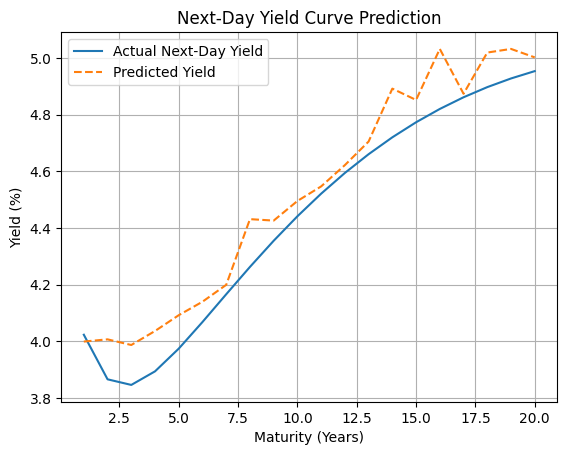

In [162]:
maturities = np.arange(1, 21)
plt.plot(maturities, true_yield[0], label='Actual Next-Day Yield')
plt.plot(maturities, predicted_yield[0], label='Predicted Yield', linestyle='--')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Next-Day Yield Curve Prediction")
plt.legend()
plt.grid(True)
plt.show()

# GRU 

## Maturity = 2 

### First version

#### === Packages ===

In [ ]:
from datetime import date
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

#### === Config ===

In [245]:
maturity_col = '2' 
time_step = 10
future_days = 35

#### === Data ===

In [246]:
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)



#yield_data2 = data2.loc[:, '2'].values
#yield_data2 = pd.DataFrame(yield_data2)
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data2 = scaler.fit_transform(yield_data2.values)
#print(yield_data2.shape)
#print(scaled_data2.shape)

##### === Create dataset ===

In [247]:
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

#X, y = create_dataset(scaled_data, time_step)
#X = X.reshape(X.shape[0], X.shape[1], 1)

print(X_train.shape) 
print(y_train.shape) 

(8189, 10, 1)
(8189, 35)


#### === Build GRU model ===

In [248]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### === Training GRU model ===

In [249]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0388 - val_loss: 9.2942e-04
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1083e-04 - val_loss: 8.8231e-04
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.3530e-04 - val_loss: 7.5030e-04
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7760e-04 - val_loss: 7.5738e-04
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0324e-04 - val_loss: 7.2392e-04
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7641e-04 - val_loss: 7.4478e-04
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7070e-04 - val_loss: 7.5557e-04
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2883e-04 - val_loss: 6.9031e-04
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1515e-04 - val_loss: 6.9226e-04
Epoch 10/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1432e-04 - val_loss: 7.0452e-04
Epoch 11/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.

#### === Predicting === 

In [250]:
last_input = X_test[-1].reshape(1, time_step, 1)
predicted_scaled = model.predict(last_input)
predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

true = scaler.inverse_transform(y_test[-1].reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


#### === Plot ===

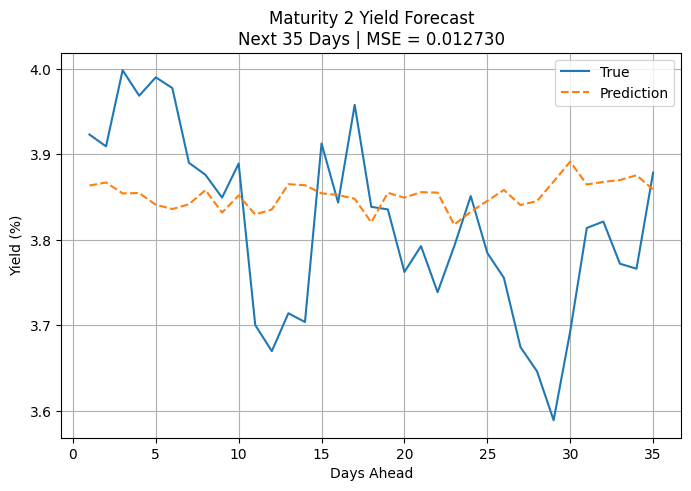

In [ ]:
mse = mean_squared_error(true, predicted)

plt.figure(figsize=(8, 5))
plt.plot(range(1, future_days + 1), true, label='True')
plt.plot(range(1, future_days + 1), predicted, label='Prediction', linestyle='--')
plt.title(f"Maturity {maturity_col} Yield Forecast\nNext {future_days} Days | MSE = {mse:.6f}")
plt.xlabel("Days Ahead")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)

### Second version

In [92]:
random_state=42
# === Config ===
maturity_col = '2'        # Choose the maturity column to predict
time_step = 365
future_days = 1

# === Extract and scale the selected maturity ===
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

# === Build model ===
model2 = Sequential()
model2.add(GRU(128, return_sequences=True, input_shape=(time_step, 1), go_backwards=True))
model2.add(Dropout(0.5))
model2.add(GRU(128))
model2.add(Dense(units=future_days))
model2.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train model ===
model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=-1)


Epoch 1/20


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Predict ===
predicted_scaled_all = model2.predict(X_test)
predicted_all = scaler.inverse_transform(predicted_scaled_all)
true_all = scaler.inverse_transform(y_test)

# === Align dates ===
aligned_test_dates = test['Date'].values[time_step + future_days:]

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_dates, true_all, label='True Yield', color='light blue' )
plt.plot(aligned_test_dates, predicted_all, label='Predicted Yield', color = 'blue')
plt.title(f"Predicted Yield for Maturity 2\nMSE = {mean_squared_error(true_all, predicted_all):.6f}")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

In [99]:
import pandas as pd

# Flatten arrays if needed
pred_flat = predicted_all.flatten()
true_flat = true_all.flatten()

# Create a DataFrame
comparison_df = pd.DataFrame({
    'Predicted': pred_flat,
    'True': true_flat
})

# Print first few rows
print(comparison_df.head(10))

   Predicted    True
0   5.009247  4.9320
1   4.976760  4.9435
2   4.957717  4.8899
3   4.930202  4.9090
4   4.916221  4.9585
5   4.923993  4.9441
6   4.926896  4.8252
7   4.890395  4.8503
8   4.868974  4.8510
9   4.857449  4.8202


In [168]:
random_state=42
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Full data ===
full_data = pd.concat([train, valid, test], axis=0).reset_index(drop=True)

# === Config ===
maturity_col = '2'
time_step = 20
future_days = 1

# === Extract and scale ===
full_vals = full_data[[maturity_col]].values
scaler = MinMaxScaler()
full_scaled = scaler.fit_transform(full_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step, future_days):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_all, y_all = create_multistep_dataset(full_scaled, time_step, future_days)
aligned_test_dates = test['Date'].values[time_step + future_days:]  # aligns with y_test
aligned_test_dates = aligned_test_dates[-len(y_test):]  # in case extra trimming needed
X_all = X_all.reshape((-1, time_step, 1))

# === Time-based splits ===
date_series = pd.to_datetime(full_data['Date'])
valid_start_idx = date_series[date_series >= pd.to_datetime('2018-01-01')].index[0]
test_start_idx = date_series[date_series >= pd.to_datetime('2025-01-01')].index[0]

# Align indices after time_step and future_days shift
offset = time_step + future_days
X_train = X_all[:valid_start_idx - offset]
y_train = y_all[:valid_start_idx - offset]
X_val = X_all[valid_start_idx - offset:test_start_idx - offset]
y_val = y_all[valid_start_idx - offset:test_start_idx - offset]
X_test = X_all[test_start_idx - offset:]
y_test = y_all[test_start_idx - offset:]

# === GRU model ===
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train ===
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=-1)

Epoch 1/20


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


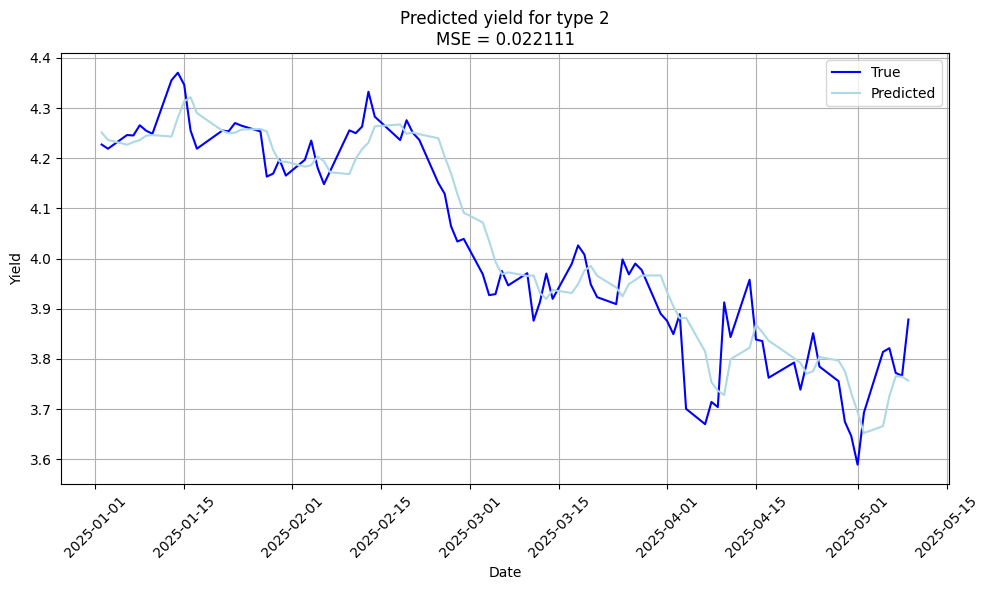

In [169]:
# === Predict ===
predicted_scaled = model.predict(X_test)
true_scaled = y_test

predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
true = scaler.inverse_transform(true_scaled.reshape(-1, 1))

# Align test dates with number of predictions
aligned_test_dates = test['Date'].values[-len(y_test):]  # This is fine IF y_test is 1D (e.g., shape (89, 1))
# 1. Determine how many actual test samples were created
expected_len = len(y_test)
# 2. Extract correct number of dates from test set, accounting for time_step and future_days
aligned_test_dates = test['Date'].values[-expected_len:]

predicted = predicted.flatten()
true = true.flatten()

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_dates, true, label='True', color='blue')
plt.plot(aligned_test_dates, predicted, label='Predicted', color = 'lightblue')
plt.title(f"Predicted yield for type 2\nMSE = {mean_squared_error(true_all, predicted_all):.6f}")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Maturity = 20

In [20]:
from keras_tuner.tuners import BayesianOptimization
from datetime import date
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

Epoch 1/50


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0500 - val_loss: 5.6482e-04
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0067 - val_loss: 5.4720e-04
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0043 - val_loss: 6.5898e-04
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0034 - val_loss: 5.6470e-04
Epoch 5/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0029 - val_loss: 5.6312e-04
Epoch 6/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0025 - val_loss: 6.0179e-04
Epoch 7/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0023 - val_loss: 5.2977e-04
Epoch 8/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0020 - val_loss: 6.8932e-04
Epoch 9/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0020 - val_loss: 7.6116e-04
Epoch 10/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0018 - val_loss: 6.9159e-04
Epoch 11/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0017 - val_loss: 5.7265e-

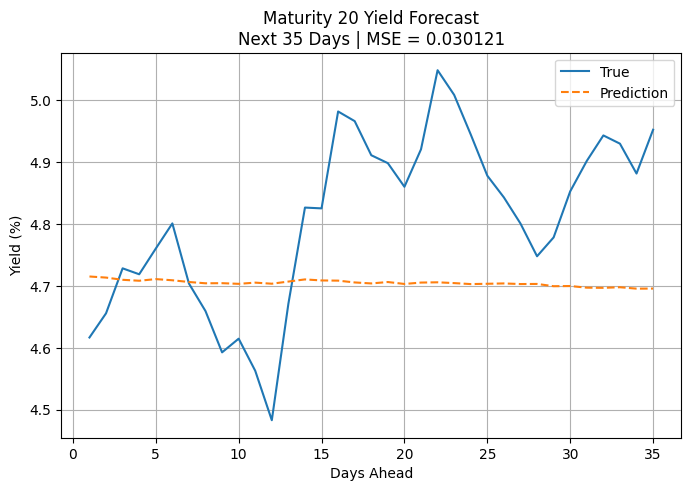

In [ ]:

# === Config ===
maturity_col = '20'        # Choose the maturity column to predict
time_step = 50
future_days = 35

# === Extract and scale the selected maturity ===
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

# === Build model ===
#model = Sequential()
#model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
#model.add(GRU(50))
#model.add(Dense(units=future_days))
#model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train model ===
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# === Predict on last test sample ===
last_input = X_test[-1].reshape(1, time_step, 1)
predicted_scaled = model.predict(last_input)
predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

true = scaler.inverse_transform(y_test[-1].reshape(-1, 1))

# === Plot ===
mse = mean_squared_error(true, predicted)

plt.figure(figsize=(8, 5))
plt.plot(range(1, future_days + 1), true, label='True')
plt.plot(range(1, future_days + 1), predicted, label='Prediction', linestyle='--')
plt.title(f"Maturity {maturity_col} Yield Forecast\nNext {future_days} Days | MSE = {mse:.6f}")
plt.xlabel("Days Ahead")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)

In [167]:
print(test)

             Date       1       2       3       4       5       6       7  \
16581  2025-01-02  4.1919  4.2189  4.2541  4.2952  4.3406  4.3886  4.4381   
16582  2025-01-03  4.2098  4.2462  4.2877  4.3329  4.3805  4.4292  4.4783   
16583  2025-01-06  4.2075  4.2453  4.2890  4.3368  4.3874  4.4393  4.4915   
16584  2025-01-07  4.2200  4.2657  4.3167  4.3712  4.4277  4.4849  4.5419   
16585  2025-01-08  4.2129  4.2549  4.3038  4.3575  4.4144  4.4728  4.5314   
...           ...     ...     ...     ...     ...     ...     ...     ...   
16668  2025-05-05  3.9972  3.8213  3.7931  3.8391  3.9211  4.0190  4.1217   
16669  2025-05-06  3.9610  3.7720  3.7439  3.7936  3.8799  3.9816  4.0876   
16670  2025-05-07  3.9754  3.7662  3.7264  3.7683  3.8488  3.9458  4.0480   
16671  2025-05-08  4.0313  3.8785  3.8559  3.9002  3.9777  4.0700  4.1671   
16672  2025-05-09  4.0236  3.8663  3.8465  3.8944  3.9746  4.0686  4.1665   

            8       9  ...      11      12      13      14      15      16 

In [170]:
random_state=42
# === Config ===
maturity_col = '20'        # Choose the maturity column to predict
time_step = 20
future_days = 1

# === Extract and scale the selected maturity ===
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

# === Build model ===
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train model ===
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=-1)

Epoch 1/20


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


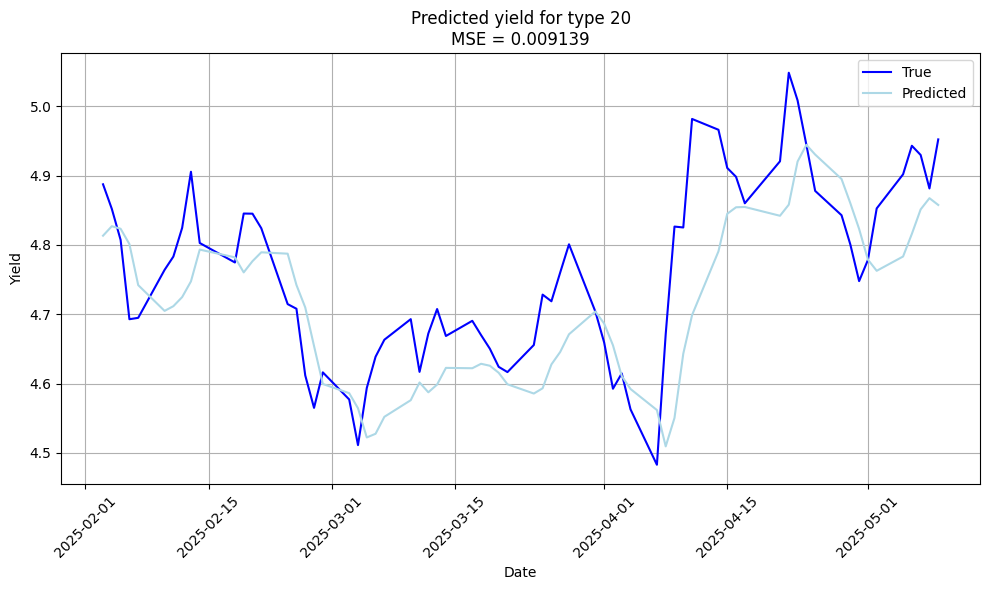

In [171]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Predict
predicted_scaled_all = model.predict(X_test)
predicted_all = scaler.inverse_transform(predicted_scaled_all)
true_all = scaler.inverse_transform(y_test)

aligned_test_dates = test['Date'].values[-len(y_test):]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_dates, true_all, label='True', color='blue')
plt.plot(aligned_test_dates, predicted_all, label='Predicted', color='lightblue')
plt.title(f"Predicted yield for type 20\nMSE = {mean_squared_error(true_all, predicted_all):.6f}")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Tuning GRU 

In [268]:
units_list = [32, 64, 128]
time_steps = [30, 60]
best_mse = float('inf')
best_model = None

for units in units_list:
    for step in time_steps:
        # recreate data with new time_step
        X_train, y_train = create_multistep_dataset(train_scaled, step, future_days)
        X_val, y_val = create_multistep_dataset(val_scaled, step, future_days)
        X_train = X_train.reshape((-1, step, 1))
        X_val = X_val.reshape((-1, step, 1))

        model = Sequential([
            GRU(units, return_sequences=True, input_shape=(step, 1)),
            GRU(units),
            Dense(future_days)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        preds = model.predict(X_val)
        mse = mean_squared_error(y_val.reshape(-1, future_days), preds)
        print(f"units: {units}, step: {step}, MSE: {mse:.6f}")

        if mse < best_mse:
            best_mse = mse
            best_model = model

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
units: 32, step: 30, MSE: 0.000532


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
units: 32, step: 60, MSE: 0.000528


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
units: 64, step: 30, MSE: 0.000555


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
units: 64, step: 60, MSE: 0.000537


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
units: 128, step: 30, MSE: 0.000503


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
units: 128, step: 60, MSE: 0.000515


In [270]:
print(f"Best MSE: {best_mse:.6f} with units={units} and time_step={step}")

Best MSE: 0.000503 with units=128 and time_step=60


# Baseline model

Naive baseline MSE: 0.003599


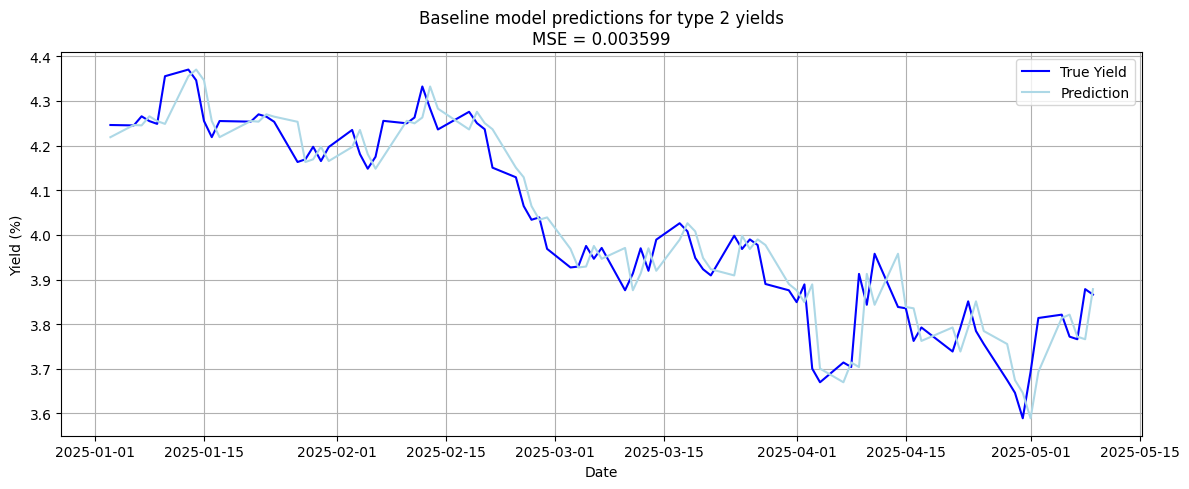

In [111]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Config ===
maturity_col = '2'  # Change to '2' for maturity 2
df = test.copy()
df['Date'] = pd.to_datetime(df['Date'])

# === Create naive predictions ===
df['Prediction'] = df[maturity_col].shift(1)  # yesterday's yield

# Drop first row (no prediction for first date)
df_naive = df.dropna(subset=['Prediction'])

# === Evaluate ===
mse = mean_squared_error(df_naive[maturity_col], df_naive['Prediction'])
print(f"Naive baseline MSE: {mse:.6f}")

# === Plot ===
plt.figure(figsize=(12, 5))
plt.plot(df_naive['Date'], df_naive[maturity_col], label='True Yield', color = 'blue')
plt.plot(df_naive['Date'], df_naive['Prediction'], label='Prediction', color = 'lightblue')
plt.title(f"Baseline model predictions for type {maturity_col} yields\nMSE = {mse:.6f}")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()